In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [2]:
df = pd.read_csv('PJME_hourly.csv')
print(df.shape)
print(df.dtypes)
df.head()

(145366, 2)
Datetime     object
PJME_MW     float64
dtype: object


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head ()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.isna().sum()

Datetime    0
PJME_MW     0
dtype: int64

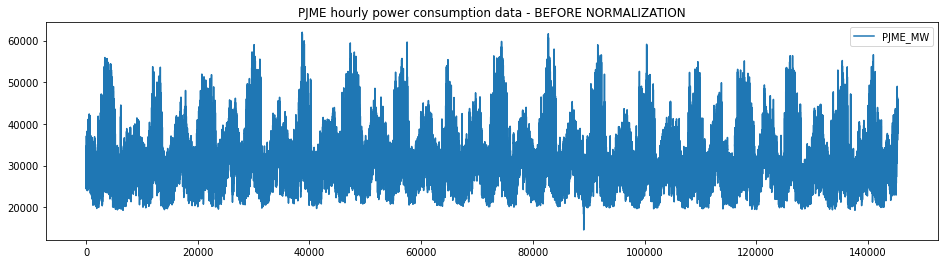

In [5]:
df.plot(figsize=(16,4),legend=True)

plt.title('PJME hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [6]:
def normalize_data(input):
    scaler = sklearn.preprocessing.MinMaxScaler()
    input['PJME_MW'] = scaler.fit_transform(input['PJME_MW'].values.reshape(-1, 1))
    return input

df_norm = normalize_data(pjme)
df_norm.shape

(145366, 1)

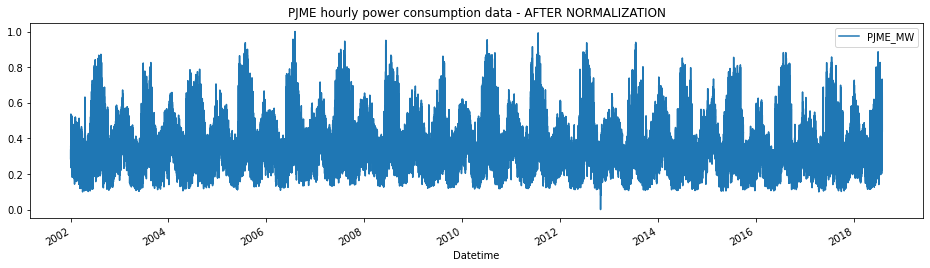

In [7]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('PJME hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [8]:
df_norm.shape

(145366, 1)

In [9]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [10]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

print (X_train[0])

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (35346, 20, 1)
y_test.shape =  (35346,)
[[0.25184873]
 [0.22338565]
 [0.2113136 ]
 [0.20750026]
 [0.21733909]
 [0.24603392]
 [0.29828295]
 [0.34033498]
 [0.36355209]
 [0.37532919]
 [0.37558201]
 [0.36570104]
 [0.34935215]
 [0.33338249]
 [0.3164437 ]
 [0.30662593]
 [0.3321184 ]
 [0.41026019]
 [0.41401032]
 [0.38440956]]


In [27]:
inputs = tf.keras.layers.Input(shape=(20, 1))
x = SimpleRNN(40, return_sequences=True)(inputs)
x = tf.keras.activations.tanh (x)
x = Dropout(0.15)(x)

x = SimpleRNN(40, input_shape=(X_train.shape[1], 1), return_sequences=True)(x)
x = tf.keras.activations.tanh (x)
x = Dropout(0.15)(x)

x = SimpleRNN(40, input_shape=(X_train.shape[1], 1), return_sequences=False)(x)
x = tf.keras.activations.tanh (x)
x = Dropout(0.15)(x)

outputs = Dense(units=1)(x)

rnn_model = tf.keras.Model(inputs, outputs)

rnn_model.summary ()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 tf.math.tanh_3 (TFOpLambda)  (None, 20, 40)           0         
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 tf.math.tanh_4 (TFOpLambda)  (None, 20, 40)           0         
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0   

In [12]:
X_train.shape

(110000, 20, 1)

In [28]:
rnn_model.compile (
    optimizer=tf.keras.optimizers.Adam (),
    loss=tf.keras.losses.MeanSquaredError()
)

In [29]:
history = rnn_model.fit (
    x=X_train,
    y=y_train,
    batch_size=1000,
    epochs=10
)

Epoch 1/10
110/110 [==============================] - 12s 93ms/step - loss: 0.0933
Epoch 2/10
110/110 [==============================] - 10s 93ms/step - loss: 0.0237
Epoch 3/10
110/110 [==============================] - 16s 143ms/step - loss: 0.0115
Epoch 4/10
110/110 [==============================] - 11s 101ms/step - loss: 0.0076
Epoch 5/10
110/110 [==============================] - 10s 93ms/step - loss: 0.0057
Epoch 6/10
110/110 [==============================] - 10s 94ms/step - loss: 0.0046
Epoch 7/10
110/110 [==============================] - 10s 94ms/step - loss: 0.0038
Epoch 8/10
110/110 [==============================] - 10s 95ms/step - loss: 0.0033
Epoch 9/10
110/110 [==============================] - 12s 108ms/step - loss: 0.0030
Epoch 10/10
110/110 [==============================] - 10s 93ms/step - loss: 0.0027


In [30]:
rnn_predictions = rnn_model.predict(X_test)
  # y_pred = np.array([i[0] for i in rnn_predictions])
  # y_pred = y_pred.reshape(-1)

  # plt.plot (y_test, label='Actual')
  # plt.plot (y_pred, label='Predicted')
  # plt.legend (loc=1)
  # plt.show ()
rnn_score = r2_score(y_test, rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9658390375547129


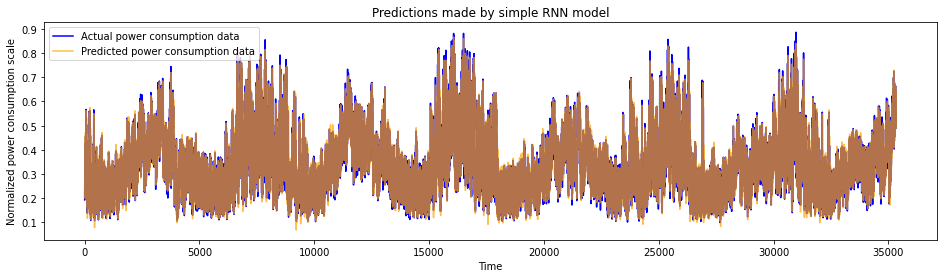

In [31]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [32]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_6 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_7 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4

In [33]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 37s 279ms/step - loss: 0.0224
Epoch 2/10
110/110 [==============================] - 28s 256ms/step - loss: 0.0115
Epoch 3/10
110/110 [==============================] - 26s 239ms/step - loss: 0.0058
Epoch 4/10
110/110 [==============================] - 26s 239ms/step - loss: 0.0043
Epoch 5/10
110/110 [==============================] - 26s 239ms/step - loss: 0.0031
Epoch 6/10
110/110 [==============================] - 27s 246ms/step - loss: 0.0024
Epoch 7/10
110/110 [==============================] - 26s 240ms/step - loss: 0.0020
Epoch 8/10
110/110 [==============================] - 26s 239ms/step - loss: 0.0017
Epoch 9/10
110/110 [==============================] - 26s 239ms/step - loss: 0.0016
Epoch 10/10
110/110 [==============================] - 27s 247ms/step - loss: 0.0015


In [34]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.958888765487482


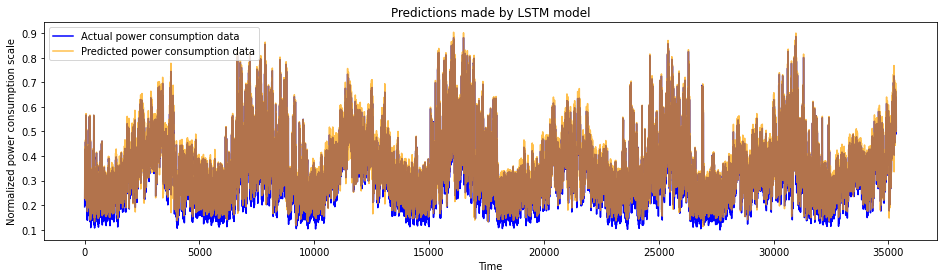

In [35]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

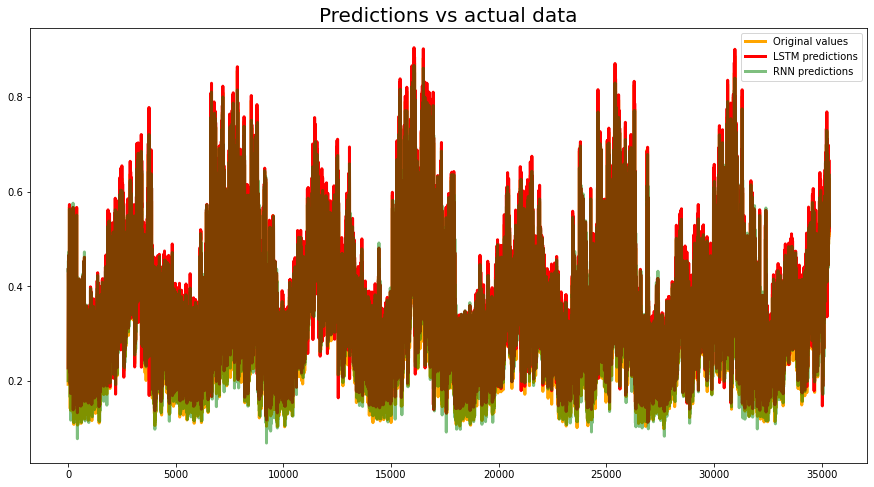

In [36]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()